# Implémentation UNet

## Importation des bibliothèques

In [20]:
# === Base Python ===
import os
import glob
import random
from pathlib import Path

# === Typage ===
from typing import Optional, Union, Tuple

# === NumPy / Pandas / Math / Visualisation ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

# === PIL (images) ===
from PIL import Image

# === PyTorch / Torchvision ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision
from torchvision import transforms

# === Monai (medical imaging) ===
import monai
from monai.transforms import LoadImage
from monai.losses import DiceLoss

# === Affichage modèle ===
from torchinfo import summary

# === Barre de progression ===
from tqdm.auto import tqdm


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

Using device: cuda
2.5.1
12.4
True


## Load PNG Data

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import re

class PngSlicesDataset(Dataset):
    def __init__(self, root_dir, resized_width=256, resized_height=256, slice_range=None, transform=None):
        self.image_paths = []
        self.mask_paths = []
        self.resized_width = resized_width
        self.resized_height = resized_height
        self.slice_range = slice_range
        self.transform = transform if transform is not None else transforms.ToTensor()

        patients = os.listdir(root_dir)
        for patient in patients:
            images_folder = os.path.join(root_dir, patient, "IRM")
            masks_folder = os.path.join(root_dir, patient, "masque")

            if not os.path.isdir(images_folder) or not os.path.isdir(masks_folder):
                continue

            image_files = sorted(os.listdir(images_folder))

            for img_file in image_files:
                # Utiliser une expression régulière pour détecter slice_XXXX.png
                match = re.match(r"slice_(\d+)\.png", img_file)
                if not match:
                    continue  # Si ce n'est pas un slice_XXXX.png, on ignore

                slice_num = int(match.group(1))

                if self.slice_range:
                    if not (self.slice_range[0] <= slice_num <= self.slice_range[1]):
                        continue

                img_path = os.path.join(images_folder, img_file)
                mask_path = os.path.join(masks_folder, img_file)

                if os.path.exists(img_path) and os.path.exists(mask_path):
                    self.image_paths.append(img_path)
                    self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('L')
        mask = Image.open(self.mask_paths[idx]).convert('L')

        resize_transform = transforms.Resize((self.resized_height, self.resized_width))

        img = resize_transform(img)
        mask = resize_transform(mask)

        img = self.transform(img)
        mask = self.transform(mask)

        img = (img - 0.5) / 0.5  # Normaliser [-1,1]
        mask = (mask > 0.5).float()  # Binariser

        return img, mask, os.path.basename(self.image_paths[idx])


## Define train, test, validation dataset

### Here we get the initial image shapes

This value is important, as it will allow us to resize our entire dataset. We must also bear in mind that the size **must be a multiple of two**. This is because, through downsampling (by a factor of two), **we want natural numbers**. 

In [ ]:
from PIL import Image
import os

def GetInitialImageShape(images_folder): 
    image_files = sorted([f for f in os.listdir(images_folder) if f.endswith('.png')])
    img = Image.open(os.path.join(images_folder, image_files[0]))
    w, h = img.size
    return (w,h)

def getNearestMultipleOfTwo(x):
    multipleOfTwo = [2**i for i in range(10)]
    mini = float('inf')
    nearest_value = None
    
    for elem in multipleOfTwo:
        difference = abs(elem - x)
        if difference < mini:
            mini = difference
            nearest_value = elem
    
    return nearest_value

Here we define `width` and `height` of our __dataset__ et autres constantes

In [28]:
w,h = GetInitialImageShape("./UNet_data_png/01016SACH/IRM")
width = getNearestMultipleOfTwo(w)
height = getNearestMultipleOfTwo(h)
slice_range = [145, 291]
LEARNING_RATE = 3e-4
BATCH_SIZE = 8
learning_rate = 0.001
n_epochs = 120
ROOT_DIR = './UNet_data_png'

In [29]:
dataset = PngSlicesDataset(
    root_dir=ROOT_DIR,
    resized_width=width,
    resized_height=height,
    slice_range=slice_range
)

num_samples = len(dataset)
indices = np.random.RandomState(seed=25).permutation(num_samples)

train_size = int(0.8 * num_samples)
test_size = int(0.1 * num_samples)
val_size = num_samples - train_size - test_size

train_idx = indices[:train_size]
test_idx = indices[train_size:train_size + test_size]
val_idx = indices[train_size + test_size:]

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
val_dataset = Subset(dataset, val_idx)


### Data loader + his test


In [30]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,batch_size=BATCH_SIZE,shuffle= False)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=1, shuffle=False)

In [31]:
# Vérification du DataLoader
for img, mask, path in  test_dataloader:
    print(f'Image batch shape: {img.shape}')
    print(f'Mask batch shape: {mask.shape}')
    print(f'Image path: {path[0]}')  # Afficher un chemin d'image pour vérifier
    break  # Juste pour vérifier une première itération

Image batch shape: torch.Size([1, 1, 256, 256])
Mask batch shape: torch.Size([1, 1, 256, 256])
Image path: slice_238.png


## Visualize data samples

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Obtenir un index aléatoire pour chaque dataset
train_idx = np.random.randint(len(train_dataset))
val_idx = np.random.randint(len(val_dataset))
test_idx = np.random.randint(len(test_dataset))

print("train_idx:", train_idx)
print("val_idx:", val_idx)
print("test_idx:", test_idx)

def plot_slice(dataset, index, dataset_name):
    batch_data = dataset[index]
    image, label = batch_data[0].to(device), batch_data[1].to(device)

    # Conversion en numpy
    image = image.squeeze().detach().cpu().numpy()
    label = label.squeeze().detach().cpu().numpy()

    image = (image + 1) / 2.0  # Normaliser [0,1]

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(f"{dataset_name} - Image")
    axes[0].axis('off')

    axes[1].imshow(image, cmap='gray')
    axes[1].imshow(label, cmap='Reds', alpha=0.4)
    axes[1].set_title(f"{dataset_name} - Overlay")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# 🔥 Afficher séparément
#plot_slice(train_dataset, train_idx, dataset_name="Training")
#plot_slice(val_dataset, val_idx, dataset_name="Validation")
#plot_slice(test_dataset, test_idx, dataset_name="Test")


## UNet Network Architecture

#### UNet params

In [32]:
# Model Architecture Parameters
input_channels = 1
num_classes  = 1      #  e.g. 1 for binary segmentation (background vs object)
input_shape = (input_channels, width, height)  # This is the shape of the input image to the network
output_shape = (num_classes, width, height)  # This is the shape of the output mask
init_channels = 32              # This is the number of channels in the first layer of the network
model_weights_path = "model_unet_no_data_traitement_120.pth"

#### The UNet model 

In [33]:
from monai.networks.nets import UNet

# Define a Unet with  monai, lighter than Class Unet 
# Creation of the model U-Net with MONAI
model = UNet(
    spatial_dims = 2,                   # 2D U-Net
    in_channels = 1,                    # e.g. 3 for RGB, 1 for grayscale input images
    out_channels = 1,                   # 1 for binary segmentation
    channels = (16, 32, 64, 128, 256),  # Nombres de canaux aux différents niveaux d'encodage
    strides = (2, 2, 2, 2),             # Strides de downsampling (modèle aura 4 niveaux) 
    num_res_units=1                     # Nombre d'unités résiduelles par bloc
).to(device)


#### Loss functions

In [34]:
# Option 1 : Utiliser Dice Loss seule => pas tres performant
# criterion = DiceLoss(sigmoid=True)

# Option 2 (recommandée) : Combiner Dice + BCE
class ComboLoss(nn.Module):
    def __init__(self, dice_weight=0.7):
        super().__init__()
        self.dice = DiceLoss(sigmoid=True)
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([20.0]).to(device))  # 20 peut être ajusté
        self.dice_weight = dice_weight

    def forward(self, inputs, targets):
        dice_loss = self.dice(inputs, targets)
        bce_loss = self.bce(inputs, targets)
        return self.dice_weight * dice_loss + (1 - self.dice_weight) * bce_loss

criterion = ComboLoss(dice_weight=0.7)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

### Function to train the model

In [43]:
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, n_epochs, min_epoch=10):
    import torch
    from tqdm import tqdm

    model = model.to(device)
    train_losses = []
    valid_losses = []

    best_diff = float('inf')
    best_model_state = None
    best_epoch = 0

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0

        for batch_data in tqdm(train_dataloader, desc=f"Epoch {epoch+1} - Training", leave=False):
            images, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_dataloader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for batch_data in tqdm(val_dataloader, desc=f"Epoch {epoch+1} - Validation", leave=False):
                val_inputs, val_labels = batch_data[0].to(device), batch_data[1].to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                valid_loss += val_loss.item() * val_inputs.size(0)

        valid_loss /= len(val_dataloader.dataset)
        valid_losses.append(valid_loss)

        diff = abs(valid_loss - train_loss)
        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {valid_loss:.4f} | Diff: {diff:.4f}")

        # Cherche le minimum de différence à partir de min_epoch
        if epoch + 1 >= min_epoch and diff < best_diff:
            best_diff = diff
            best_model_state = model.state_dict()
            best_epoch = epoch + 1

    print(f"\n✅ Best model selected at epoch {best_epoch} (after epoch {min_epoch}) with |Train - Val| loss diff: {best_diff:.4f}")
    
    return best_model_state, train_losses, valid_losses, best_epoch


### We save the model

In [44]:
def SaveModel(best_model, model_path, best_epoch):
    model.load_state_dict(best_model)
    torch.save(best_model, model_path)
    print(f"Best model selected at epoch {best_epoch} with validation loss: {best_valid_loss:.4f}")

def SaveTrainAndValidLosses(csv_path):
    loss_df = pd.DataFrame({
        'epoch': list(range(1, len(train_losses) + 1)),
        'train_loss': train_losses,
        'valid_loss': valid_losses
    })
    loss_df.to_csv(csv_path, index=False)
    print(f"📁 Losses saved to '{csv_path}'")

### Train and Save

In [ ]:
best_model_state, train_losses, valid_losses, best_epoch = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    n_epochs=n_epochs,
    min_epoch=50
)

SaveModel(best_model_state, model_weights_path, best_epoch)


Epoch 1/120 | Train Loss: 0.8060 | Val Loss: 0.8057 | Diff: 0.0004


Epoch 2/120 | Train Loss: 0.7979 | Val Loss: 0.7968 | Diff: 0.0011


Epoch 3/120 | Train Loss: 0.7867 | Val Loss: 0.7791 | Diff: 0.0076


Epoch 4 - Validation:  75%|█████████████████████████████████████████████               | 21/28 [00:03<00:01,  4.91it/s]

### Display Train Curves 

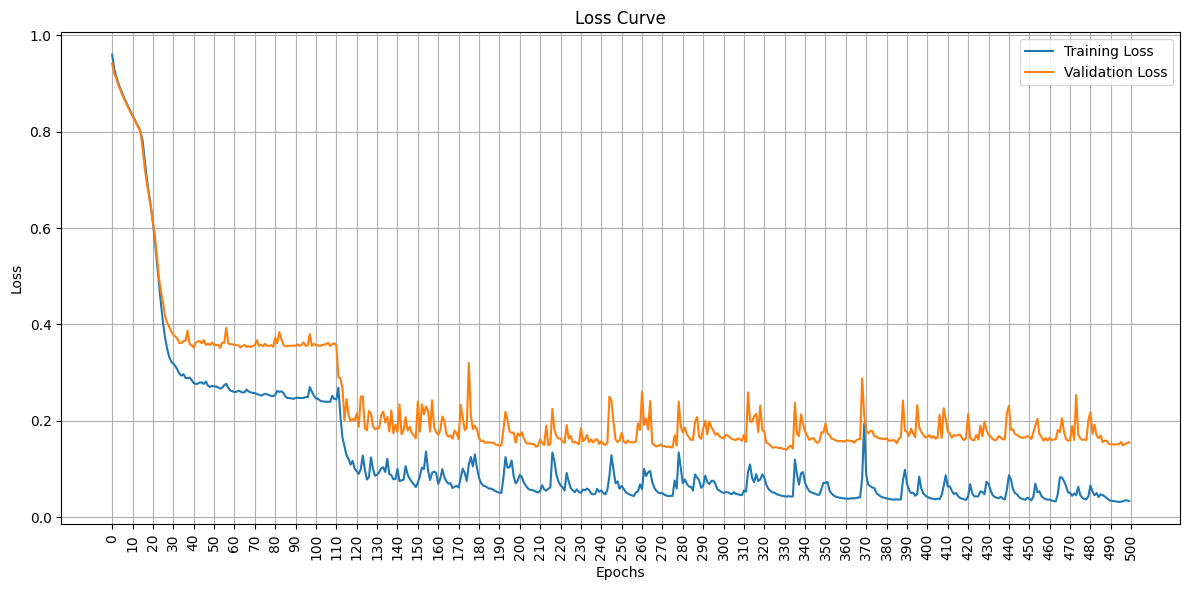

In [26]:
# Save data
# SaveTrainAndValidLosses("train_and_losses_500_epochs.csv")


plt.figure(figsize=(12, 6))  # plot plus large

# Tracer les courbes
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Grille activée
plt.grid(True)

# Ticks tous les 10 epochs
num_epochs = len(train_losses)
plt.xticks(range(0, num_epochs + 1, 10), rotation=90)  # valeurs horizontales

plt.tight_layout()  # évite que le texte soit coupé
plt.show()


## Load and test the "best" model

In [ ]:
model.load_state_dict(torch.load(model_weights_path))

Image shape: torch.Size([1, 1, 256, 256])


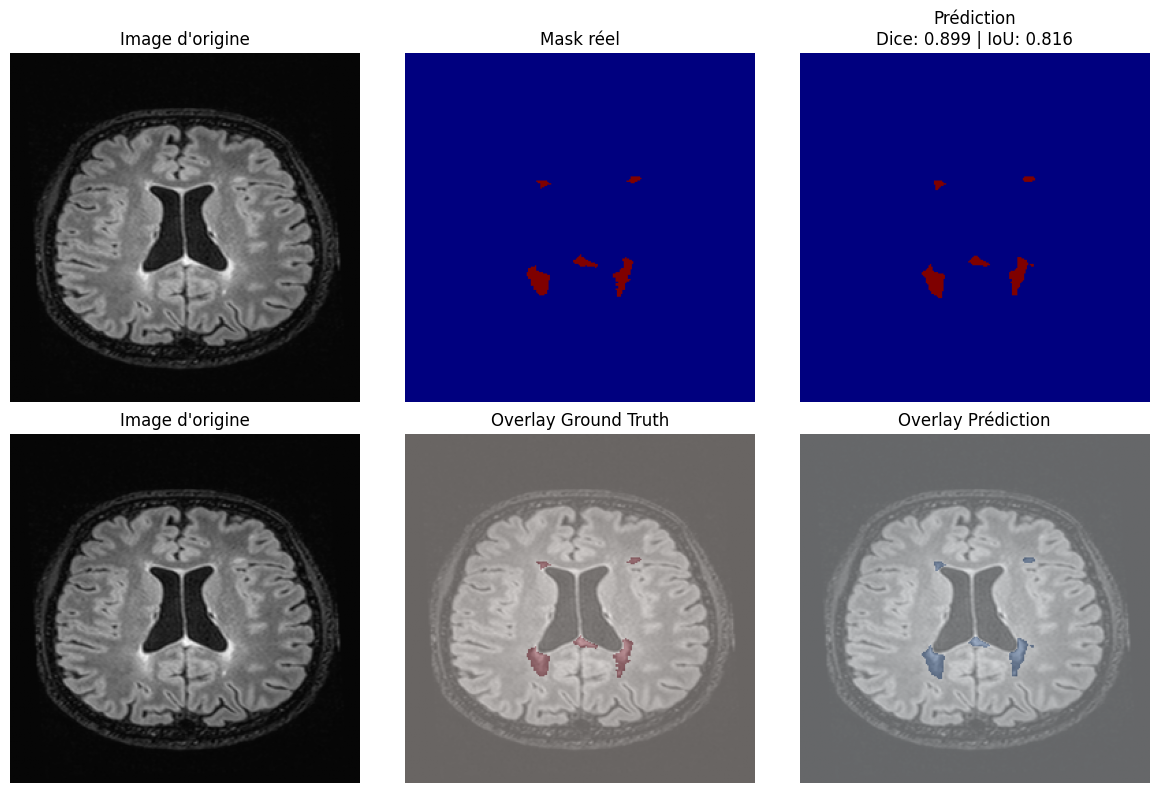

✅ Dice (MONAI) : 0.899
✅ IoU  (MONAI) : 0.816
✅ Dice (NumPy) : 0.899
✅ IoU  (NumPy) : 0.816


In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from monai.networks.nets import UNet
from sklearn.metrics import jaccard_score
from monai.metrics import DiceMetric, MeanIoU

# --- METRICS MONAI ---
dice_metric = DiceMetric(include_background=False, reduction="mean")
iou_metric = MeanIoU(include_background=False)

# --- METRICS numpy ---
def dice_score(pred, label):
    pred = pred.astype(np.bool_)
    label = label.astype(np.bool_)
    intersection = np.logical_and(pred, label).sum()
    return 2. * intersection / (pred.sum() + label.sum() + 1e-8)

def iou_score(pred, label):
    pred = pred.astype(np.bool_)
    label = label.astype(np.bool_)
    intersection = np.logical_and(pred, label).sum()
    union = np.logical_or(pred, label).sum()
    return intersection / (union + 1e-8)

# --- FONCTION D'ÉVALUATION ---
def evaluate_model_on_batch(model, dataloader, device):
    model = model.to(device)
    model.eval()

    dice_metric.reset()
    iou_metric.reset()

    batch_data = next(iter(dataloader))  # prend un batch

    with torch.no_grad():
        images, labels, names = batch_data  # attention ici : dataset retourne aussi les noms !
        images = images.to(device)
        labels = labels.to(device)

        # prendre seulement la première image du batch
        image = images[0].unsqueeze(0)  # [1, 1, H, W]
        label = labels[0].unsqueeze(0)  # [1, 1, H, W]

        print("Image shape:", image.shape)

        preds = model(image)

        # Appliquer sigmoid + threshold
        preds = torch.sigmoid(preds)
        preds = (preds > 0.5).float()

        # Calcul MONAI metrics
        dice_metric(preds, label)
        iou_metric(preds, label)
        dice_metric_result = dice_metric.aggregate().item()
        iou_metric_result = iou_metric.aggregate().item()

        # --- Conversion numpy pour affichage ---
        image_np = image.squeeze().detach().cpu().numpy()
        label_np = label.squeeze().detach().cpu().numpy()
        preds_np = preds.squeeze().detach().cpu().numpy()

        # Normaliser l'image [-1,1] → [0,1]
        image_np = (image_np + 1) / 2.0

        # Calcul numpy metrics
        dice = dice_score(preds_np, label_np)
        iou = iou_score(preds_np, label_np)

    # --- AFFICHAGE ---
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    axes[0, 0].imshow(image_np, cmap="gray")
    axes[0, 0].set_title("Image d'origine")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(label_np, cmap="jet")
    axes[0, 1].set_title("Mask réel")
    axes[0, 1].axis("off")

    axes[0, 2].imshow(preds_np, cmap="jet")
    axes[0, 2].set_title(f"Prédiction\nDice: {dice:.3f} | IoU: {iou:.3f}")
    axes[0, 2].axis("off")

    axes[1, 0].imshow(image_np, cmap="gray")
    axes[1, 0].set_title("Image d'origine")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(image_np, cmap="gray")
    axes[1, 1].imshow(label_np, cmap="Reds", alpha=0.4)
    axes[1, 1].set_title("Overlay Ground Truth")
    axes[1, 1].axis("off")

    axes[1, 2].imshow(image_np, cmap="gray")
    axes[1, 2].imshow(preds_np, cmap="Blues", alpha=0.4)
    axes[1, 2].set_title("Overlay Prédiction")
    axes[1, 2].axis("off")

    plt.tight_layout()
    plt.show()

    print(f"✅ Dice (MONAI) : {dice_metric_result:.3f}")
    print(f"✅ IoU  (MONAI) : {iou_metric_result:.3f}")
    print(f"✅ Dice (NumPy) : {dice:.3f}")
    print(f"✅ IoU  (NumPy) : {iou:.3f}")

# --- UTILISATION ---
# Exemple :
# model = UNet(...)  # Ton modèle déjà chargé
# test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=1)

evaluate_model_on_batch(model, test_dataloader, device)
